In [4]:
from sys import path

path.append("../")

from gc import collect as garbage_collect

from joblib import Parallel, delayed
from numpy import ndarray, stack
from pandas import DataFrame, Series, option_context as pandas_option_context
from tqdm.auto import tqdm
from lazypredict.Supervised import LazyClassifier

from src.feature_extraction.eda import get_eda_features
from src.utils.experiment_info import ExperimentInfo
from src.utils.io import load_processed_data, filter_sleep_nights
from src.utils.misc import get_all_users
from src.utils.plots import (
    make_biometrics_plots_together_matplotlib,
    plot_binary_labels,
)
from src.utils.segmentation import segment
from src.utils.misc import get_labels_counts
from src.ml import resampling, local_resampling
from src.ml.cv import run_cross_validation_prediction
from src.ml.loso import run_same_side_classifications, run_different_classifications

# Intro

This notebook is intended to provide data exploration for all datasets concerning this Lateralization study. As the moment, the datasets impemented are:
* USILaughs
* MWC2022 study

I split the same notebook into 2, since I was having problems w/ remote working, due too large filesizes.

# Data Preparation

The artefacts scripts have been moved inside the EDA filtering.

## Sleep Info

In [2]:
path_to_experiment_info: str = '../data.nosync/mwc2022/all_experimento_info.csv'
experiment_info = ExperimentInfo(path=path_to_experiment_info, mode=2)
experiment_info.filter_correct_times(inplace=True)

## Physiological Data

In [3]:
eda_data_base_path: str = "../data.nosync/mwc2022/filtered/*/EDA/*.parquet"

eda_data = load_processed_data(path=eda_data_base_path, file_format="parquet")
garbage_collect()

Loading data:   0%|          | 0/19 [00:00<?, ?it/s]

469

In [5]:
eda_data = filter_sleep_nights(data=eda_data, experiment_info=experiment_info.to_df())

flitering user progress:   0%|          | 0/8 [00:00<?, ?it/s]

Removed 9 sessions


In [4]:
users = get_all_users(eda_data)
output_folder: str = "../visualizations/"
for user in tqdm(sorted(users), desc="Plotting user data", colour="red"):
    
    sessions_all_left = sorted(eda_data["left"][user].index.get_level_values(0).unique())
    sessions_all_right = sorted(eda_data["right"][user].index.get_level_values(0).unique())
    sessions_all = sorted(set(sessions_all_left) & set(sessions_all_right))
    
    for session in sessions_all:
        make_biometrics_plots_together_matplotlib(
            data={"EDA": eda_data},
            user_id=user,
            session_id=session,
            dataset="mwc2022",
            experiment_info=experiment_info.to_df(),
            eda_type="mixed-EDA",
            output_folder=output_folder
        )

Plotting user data:   0%|          | 0/32 [00:00<?, ?it/s]

In [6]:
users_in_left_side = set(eda_data['left'].keys())
users_in_right_side = set(eda_data['right'].keys())
print(f"Number of users with both left and right hand data: {len(users_in_left_side & users_in_right_side)}")

Number of users with both left and right hand data: 8


## Segmentation

The segmentation will be performed over `baseline_1` and `cognitive_load` periods. Other baselines are not considered, since they were very short periods performed after some activity, one of which was cognitive load itself. As such, brian phenomena from those activites might propagate in the EDA signal and make the classification harded.

In [7]:
segment_size_in_mins = 10
segment_size_in_secs = segment_size_in_mins * 60
eda_sample_rate = 4
segment_size_in_sampling_rate: int = segment_size_in_secs * eda_sample_rate

In [9]:
(
    values_left,
    values_right,
    labels_left,
    labels_right,
    groups_left,
    groups_right,
    artefacts_left,
    artefacts_right,
) = segment(
    data=eda_data,
    experiment_info_as_dict=experiment_info.to_dict(),
    segment_size_in_sampling_rate=segment_size_in_sampling_rate,
    segment_size_in_secs=segment_size_in_secs,
    data_sample_rate=eda_sample_rate,
    mode=2,
    artefact=True,
)


User progress:   0%|          | 0/8 [00:00<?, ?it/s]

KeyError: 'Artifact'

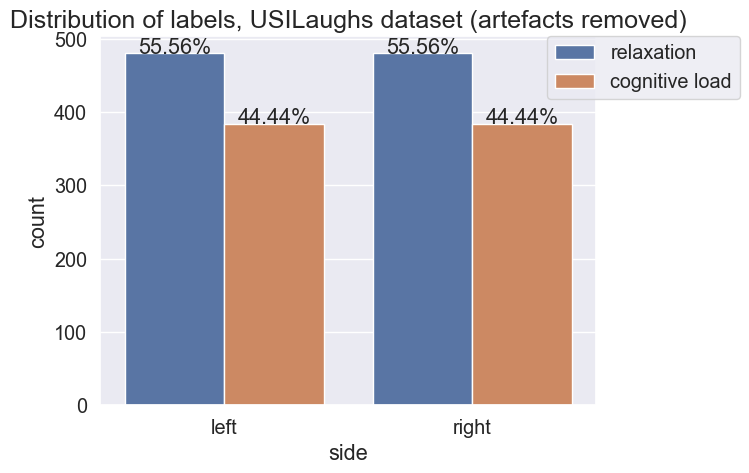

In [7]:
counts = get_labels_counts(labels_left, labels_right, ['relaxation', 'cognitive load'])
plot_binary_labels(
    counts=counts,
    title="Distribution of labels, USILaughs dataset (artefacts removed)",
    dataset_name="usilaughs_noartefacts",
    output_folder="../visualizations/"
)


The distribution is almost balanced: as such, re-balancing should not be a large problem.

## Artefact Removal

In the previous notebook, the training of the model was done without regard for possible artefacts, present in the data. However, it is quite easy to have artefact in EDA data. As such, to methods shall be proposed here for artefact removal.

1. Using Shkurta's method (see https://github.com/shkurtagashi/EDArtifact)
2. Using a simple acc-based logic. The threshold will be decided upon visual inspection and looking at similar literature.

Both methods have been implemented inside the EDA filtering scripts. (only 1 at the moment, but second will follow soon)

## Feature Extraction

In [8]:
features_left = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_left)
)
features_right = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_right)
)

features_left: ndarray = stack(features_left)
features_right: ndarray = stack(features_right)

labels_left: ndarray = stack(labels_left)
labels_right: ndarray = stack(labels_right)

groups_left: ndarray = stack(groups_left)
groups_right: ndarray = stack(groups_right)

artefacts_left: ndarray = stack(artefacts_left)
artefacts_right: ndarray = stack(artefacts_right)


/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda

In [9]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")
print(f"{artefacts_left.shape=}")

features_left.shape=(864, 11)
labels_left.shape=(864,)
groups_left.shape=(864,)
artefacts_left.shape=(864,)


### Artefact Removal

In [10]:
features_left = features_left[~artefacts_left.astype(bool)]
labels_left = labels_left[~artefacts_left.astype(bool)]
groups_left = groups_left[~artefacts_left.astype(bool)]

features_right = features_right[~artefacts_right.astype(bool)]
labels_right = labels_right[~artefacts_right.astype(bool)]
groups_right = groups_right[~artefacts_right.astype(bool)]

In [11]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")
print(f"{artefacts_left.shape=}")

features_left.shape=(832, 11)
labels_left.shape=(832,)
groups_left.shape=(832,)
artefacts_left.shape=(864,)


In [12]:
print('Percentage of data removed: %.2f%% ' % (abs(1 - artefacts_left.shape[0]/features_left.shape[0])*100))

Percentage of data removed: 3.85% 


In [13]:
x = features_left
y = labels_left
groups = groups_left
data = DataFrame(x, index=groups)
data["label"] = y
len(data.loc['s055', 'label'].unique())

1

# Machine Learning

## 5-fold CV (one seed)

In [14]:
model_selected: str = "RandomForestClassifier"
metrics_selected: str = "Accuracy"

#### LX v LX

In [15]:
averaged_results_cv_lxlx, all_results_cv_lxlx = run_cross_validation_prediction(
    x=features_left,
    y=labels_left,
    groups=groups_left,
    generator_seeds=[42, 666],
    n_seeds_to_test_classifiers=1,
    n_seeds_to_test_folds=1,
)


Only one class in the dataset. Removing current user s055 <class 'RuntimeWarning'>


100%|██████████| 29/29 [00:00<00:00, 46.12it/s]


In [16]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_cv_lxlx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.7680            0.7681  0.7681   0.7678   
RandomForestClassifier          0.7625            0.7625  0.7625   0.7622   
XGBClassifier                   0.7569            0.7570  0.7570   0.7567   
BaggingClassifier               0.7555            0.7556  0.7556   0.7553   
LGBMClassifier                  0.7417            0.7417  0.7417   0.7416   
KNeighborsClassifier            0.7211            0.7212  0.7212   0.7209   
NuSVC                           0.7183            0.7185  0.7185   0.7171   
SVC                             0.7169            0.7171  0.7171   0.7160   
LabelPropagation                0.7169            0.7170  0.7170   0.7164   
LabelSpreading                  0.7155            0.7156  0.7156   0.7149   
DecisionTreeClassifier          0.6962            0.6962  0.6962   0.6956   
ExtraTreeClassifier             0.6962            0.6963  0.6963   0.6958   
AdaBoostClassifier              0.6879            0.6878  0.6878   0.6858   
CalibratedClassifierCV          0.6368            0.6371  0.6371   0.6355   
RidgeClassifier                 0.6368            0.6370  0.6370   0.6354   
LinearSVC                       0.6354            0.6357  0.6357   0.6344   
LinearDiscriminantAnalysis      0.6340            0.6343  0.6343   0.6326   
NearestCentroid                 0.6313            0.6315  0.6315   0.6301   
RidgeClassifierCV               0.6285            0.6287  0.6287   0.6270   
BernoulliNB                     0.6285            0.6287  0.6287   0.6259   
LogisticRegression              0.6230            0.6232  0.6232   0.6220   
PassiveAggressiveClassifier     0.6091            0.6088  0.6088   0.5737   
SGDClassifier                   0.5733            0.5733  0.5733   0.5701   
GaussianNB                      0.5732            0.5733  0.5733   0.5125   
QuadraticDiscriminantAnalysis   0.5635            0.5636  0.5636   0.4973   
Perceptron                      0.5456            0.5457  0.5457   0.5411   
DummyClassifier                 0.4972            0.5000  0.5000   0.3303   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0719         0.0155            0.0155   
RandomForestClassifier            0.1045         0.0216            0.0216   
XGBClassifier                     0.0681         0.0133            0.0133   
BaggingClassifier                 0.0255         0.0237            0.0236   
LGBMClassifier                    0.0311         0.0154            0.0155   
KNeighborsClassifier              0.0057         0.0253            0.0253   
NuSVC                             0.0140         0.0209            0.0209   
SVC                               0.0116         0.0197            0.0196   
LabelPropagation                  0.0071         0.0208            0.0207   
LabelSpreading                    0.0087         0.0218            0.0217   
DecisionTreeClassifier            0.0066         0.0122            0.0123   
ExtraTreeClassifier               0.0039         0.0171            0.0170   
AdaBoostClassifier                0.0528         0.0172            0.0172   
CalibratedClassifierCV            0.1062         0.0264            0.0265   
RidgeClassifier                   0.0044         0.0184            0.0184   
LinearSVC                         0.0282         0.0243            0.0244   
LinearDiscriminantAnalysis        0.0042         0.0184            0.0184   
NearestCentroid                   0.0333         0.0192            0.0193   
RidgeClassifierCV                 0.0045         0.0182            0.0182   
BernoulliNB               

#### RX vs RX

In [17]:
averaged_results_cv_rxrx, all_results_cv_rxrx = run_cross_validation_prediction(
    x=features_right,
    y=labels_right,
    groups=groups_right,
    generator_seeds=[42, 666],
    n_seeds_to_test_classifiers=1,
    n_seeds_to_test_folds=1,
)

100%|██████████| 29/29 [00:00<00:00, 46.87it/s]


In [18]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_cv_rxrx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier          0.8106            0.8107  0.8107   0.8104   
LGBMClassifier                  0.8050            0.8051  0.8051   0.8046   
KNeighborsClassifier            0.8008            0.8007  0.8007   0.8004   
XGBClassifier                   0.7967            0.7967  0.7967   0.7965   
ExtraTreesClassifier            0.7953            0.7953  0.7953   0.7950   
AdaBoostClassifier              0.7897            0.7897  0.7897   0.7892   
NuSVC                           0.7828            0.7827  0.7827   0.7823   
BaggingClassifier               0.7800            0.7800  0.7800   0.7793   
SVC                             0.7661            0.7660  0.7660   0.7657   
LabelSpreading                  0.7660            0.7660  0.7660   0.7656   
LabelPropagation                0.7632            0.7632  0.7632   0.7628   
DecisionTreeClassifier          0.7605            0.7606  0.7606   0.7600   
ExtraTreeClassifier             0.7534            0.7534  0.7534   0.7527   
CalibratedClassifierCV          0.7020            0.7019  0.7019   0.7016   
NearestCentroid                 0.7019            0.7019  0.7019   0.7017   
LinearSVC                       0.6992            0.6991  0.6991   0.6988   
LinearDiscriminantAnalysis      0.6991            0.6991  0.6991   0.6987   
RidgeClassifierCV               0.6964            0.6963  0.6963   0.6958   
RidgeClassifier                 0.6964            0.6963  0.6963   0.6959   
BernoulliNB                     0.6964            0.6963  0.6963   0.6956   
LogisticRegression              0.6936            0.6935  0.6935   0.6932   
GaussianNB                      0.6907            0.6903  0.6903   0.6856   
Perceptron                      0.6616            0.6616  0.6616   0.6558   
QuadraticDiscriminantAnalysis   0.6601            0.6606  0.6606   0.6416   
SGDClassifier                   0.6504            0.6508  0.6508   0.6390   
PassiveAggressiveClassifier     0.6240            0.6245  0.6245   0.6084   
DummyClassifier                 0.4986            0.5000  0.5000   0.3318   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier            0.1021         0.0104            0.0105   
LGBMClassifier                    0.0323         0.0162            0.0163   
KNeighborsClassifier              0.0057         0.0106            0.0107   
XGBClassifier                     0.0652         0.0176            0.0176   
ExtraTreesClassifier              0.0679         0.0124            0.0124   
AdaBoostClassifier                0.0527         0.0162            0.0162   
NuSVC                             0.0119         0.0187            0.0187   
BaggingClassifier                 0.0243         0.0156            0.0156   
SVC                               0.0102         0.0143            0.0143   
LabelSpreading                    0.0088         0.0152            0.0152   
LabelPropagation                  0.0073         0.0143            0.0143   
DecisionTreeClassifier            0.0060         0.0154            0.0154   
ExtraTreeClassifier               0.0041         0.0147            0.0147   
CalibratedClassifierCV            0.1043         0.0163            0.0164   
NearestCentroid                   0.0296         0.0153            0.0153   
LinearSVC                         0.0276         0.0183            0.0184   
LinearDiscriminantAnalysis        0.0042         0.0194            0.0194   
RidgeClassifierCV                 0.0045         0.0160            0.0161   
RidgeClassifier                   0.0044         0.0184            0.0184   
BernoulliNB               

#### Visualizing differences

In [19]:
selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "rx vs rx")
    for seed_res in all_results_cv_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx")
    for seed_res in all_results_cv_lxlx
    for single_result in seed_res
]

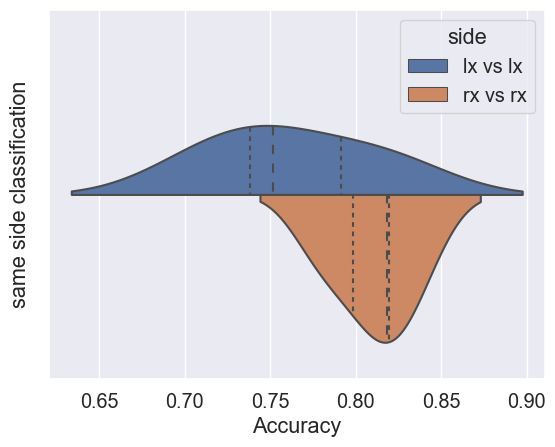

In [20]:
from seaborn import violinplot

extra_col_name: str = 'same side classification'
data_to_plot = DataFrame([*selected_results_lxlx, *selected_results_rxrx], columns=[metrics_selected, "side"])
data_to_plot[extra_col_name] = ""
ax = violinplot(data_to_plot, x=metrics_selected, y=extra_col_name, hue='side', split=True, inner='quartile')
# ax.set_ylim(0.5, 1.0)

#### LX vs RX

In [21]:
clf = LazyClassifier(predictions=True, random_state=42)

x_resampled_lx, y_resampled_lx, _ = local_resampling(features_left, labels_left, groups_left)
x_resampled_rx, y_resampled_rx, _ = local_resampling(features_right, labels_right, groups_right)
models_lxrx, _ = clf.fit(x_resampled_lx, x_resampled_rx, y_resampled_lx, y_resampled_rx)

Only one class in the dataset. Removing current user s055 <class 'RuntimeWarning'>


100%|██████████| 29/29 [00:01<00:00, 24.75it/s]


In [22]:
models_lxrx.sort_values(by="Balanced Accuracy", ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.78,0.78,0.78,0.78,0.03
NuSVC,0.77,0.77,0.77,0.77,0.04
ExtraTreesClassifier,0.75,0.75,0.75,0.75,0.08
RandomForestClassifier,0.74,0.74,0.74,0.74,0.15
KNeighborsClassifier,0.73,0.73,0.73,0.73,0.01
LGBMClassifier,0.72,0.72,0.72,0.72,0.36
LabelSpreading,0.72,0.72,0.72,0.72,0.03
LabelPropagation,0.71,0.71,0.71,0.71,0.03
AdaBoostClassifier,0.71,0.71,0.71,0.70,0.06


#### RX vs LX

In [23]:
clf = LazyClassifier(predictions=True, random_state=42)

x_resampled_rx, y_resampled_rx, _ = local_resampling(features_right, labels_right, groups_right)
x_resampled_lx, y_resampled_lx, _ = local_resampling(features_left, labels_left, groups_left)
models_rxrx, predictions = clf.fit(x_resampled_rx, x_resampled_lx, y_resampled_rx, y_resampled_lx)

Only one class in the dataset. Removing current user s055 <class 'RuntimeWarning'>


100%|██████████| 29/29 [00:01<00:00, 25.42it/s]


In [24]:
models_rxrx.sort_values(by="Balanced Accuracy", ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.72,0.72,0.72,0.72,0.39
RandomForestClassifier,0.72,0.72,0.72,0.72,0.15
KNeighborsClassifier,0.71,0.71,0.71,0.71,0.01
ExtraTreesClassifier,0.71,0.71,0.71,0.71,0.07
XGBClassifier,0.71,0.71,0.71,0.71,0.07
BaggingClassifier,0.70,0.70,0.70,0.70,0.03
LabelSpreading,0.70,0.70,0.70,0.70,0.01
LabelPropagation,0.70,0.70,0.70,0.70,0.03
AdaBoostClassifier,0.69,0.69,0.69,0.69,0.06


## 5-fold CV - different seeds

### LX vs LX

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [25]:
averaged_results_cv_multi_lxlx, all_results_cv_multi_lxlx = run_cross_validation_prediction(
    x=features_left,
    y=labels_left,
    groups=groups_left,
    generator_seeds=[42, 666],
    n_seeds_to_test_classifiers=10,
    n_seeds_to_test_folds=10,
)

Only one class in the dataset. Removing current user s055 <class 'RuntimeWarning'>


Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 48.74it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 48.76it/s]

100%|██████████| 29/29 [00:00<00:00, 48.95it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 48.63it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 48.39it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 48.42it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 48.69it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 48.62it/s]

100%|██████████| 29/29 [00:00<00:00, 48.35it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 48.93it/s]

100%|██████████| 29/29 [00:00<00:00, 49.01it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 48.72it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 48.62it/s]


In [26]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_cv_multi_lxlx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.7763            0.7764  0.7764   0.7759   
RandomForestClassifier          0.7672            0.7672  0.7672   0.7665   
LGBMClassifier                  0.7551            0.7551  0.7551   0.7545   
XGBClassifier                   0.7522            0.7522  0.7522   0.7516   
BaggingClassifier               0.7481            0.7481  0.7481   0.7474   
SVC                             0.7228            0.7228  0.7228   0.7221   
LabelPropagation                0.7218            0.7219  0.7219   0.7213   
LabelSpreading                  0.7212            0.7212  0.7212   0.7206   
NuSVC                           0.7207            0.7208  0.7208   0.7198   
DecisionTreeClassifier          0.7202            0.7202  0.7202   0.7194   
AdaBoostClassifier              0.7200            0.7200  0.7200   0.7186   
KNeighborsClassifier            0.7088            0.7089  0.7089   0.7083   
ExtraTreeClassifier             0.6866            0.6867  0.6867   0.6861   
CalibratedClassifierCV          0.6326            0.6326  0.6326   0.6317   
RidgeClassifier                 0.6316            0.6316  0.6316   0.6307   
LinearSVC                       0.6308            0.6308  0.6308   0.6299   
LinearDiscriminantAnalysis      0.6300            0.6300  0.6300   0.6290   
NearestCentroid                 0.6293            0.6293  0.6293   0.6283   
LogisticRegression              0.6290            0.6290  0.6290   0.6280   
RidgeClassifierCV               0.6279            0.6279  0.6279   0.6269   
BernoulliNB                     0.6245            0.6245  0.6245   0.6220   
SGDClassifier                   0.5746            0.5747  0.5747   0.5630   
GaussianNB                      0.5689            0.5689  0.5689   0.5082   
QuadraticDiscriminantAnalysis   0.5615            0.5614  0.5614   0.5145   
Perceptron                      0.5611            0.5611  0.5611   0.5453   
PassiveAggressiveClassifier     0.5411            0.5411  0.5411   0.5141   
DummyClassifier                 0.4972            0.5000  0.5000   0.3303   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0691         0.0019            0.0019   
RandomForestClassifier            0.1023         0.0019            0.0019   
LGBMClassifier                    0.0307         0.0017            0.0017   
XGBClassifier                     0.0669         0.0018            0.0018   
BaggingClassifier                 0.0246         0.0018            0.0018   
SVC                               0.0114         0.0018            0.0018   
LabelPropagation                  0.0069         0.0018            0.0017   
LabelSpreading                    0.0088         0.0017            0.0017   
NuSVC                             0.0138         0.0018            0.0018   
DecisionTreeClassifier            0.0061         0.0021            0.0021   
AdaBoostClassifier                0.0506         0.0018            0.0018   
KNeighborsClassifier              0.0055         0.0019            0.0019   
ExtraTreeClassifier               0.0039         0.0019            0.0019   
CalibratedClassifierCV            0.1032         0.0019            0.0019   
RidgeClassifier                   0.0043         0.0018            0.0018   
LinearSVC                         0.0278         0.0018            0.0018   
LinearDiscriminantAnalysis        0.0041         0.0018            0.0018   
NearestCentroid                   0.0039         0.0021            0.0021   
LogisticRegression                0.0059         0.0017            0.0017   
RidgeClassifierCV         

### RX vs RX

In [27]:
averaged_results_cv_multi_rxrx, all_results_cv_multi_rxrx = run_cross_validation_prediction(
    x=features_right,
    y=labels_right,
    groups=groups_right,
    generator_seeds=[42, 666],
    n_seeds_to_test_classifiers=10,
    n_seeds_to_test_folds=10,
)

Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 48.46it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 49.66it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 50.07it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 48.70it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 50.22it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 52.24it/s]

100%|██████████| 29/29 [00:00<00:00, 49.80it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 50.06it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 50.07it/s]

100%|██████████| 29/29 [00:00<00:00, 48.30it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 49.88it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 50.07it/s]


In [28]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_cv_multi_rxrx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier          0.8098            0.8099  0.8099   0.8096   
ExtraTreesClassifier            0.8059            0.8060  0.8060   0.8057   
LGBMClassifier                  0.8012            0.8013  0.8013   0.8010   
XGBClassifier                   0.7990            0.7990  0.7990   0.7988   
BaggingClassifier               0.7949            0.7949  0.7949   0.7946   
KNeighborsClassifier            0.7887            0.7887  0.7887   0.7885   
AdaBoostClassifier              0.7786            0.7786  0.7786   0.7782   
NuSVC                           0.7734            0.7734  0.7734   0.7731   
SVC                             0.7685            0.7685  0.7685   0.7682   
LabelSpreading                  0.7645            0.7645  0.7645   0.7641   
DecisionTreeClassifier          0.7639            0.7639  0.7639   0.7636   
LabelPropagation                0.7602            0.7602  0.7602   0.7598   
ExtraTreeClassifier             0.7356            0.7356  0.7356   0.7352   
NearestCentroid                 0.7040            0.7040  0.7040   0.7036   
GaussianNB                      0.7025            0.7025  0.7025   0.6992   
LinearDiscriminantAnalysis      0.6981            0.6981  0.6981   0.6977   
BernoulliNB                     0.6975            0.6975  0.6975   0.6965   
CalibratedClassifierCV          0.6968            0.6968  0.6968   0.6964   
RidgeClassifierCV               0.6961            0.6961  0.6961   0.6957   
LinearSVC                       0.6960            0.6960  0.6960   0.6957   
LogisticRegression              0.6943            0.6943  0.6943   0.6940   
RidgeClassifier                 0.6935            0.6935  0.6935   0.6931   
SGDClassifier                   0.6400            0.6400  0.6400   0.6330   
QuadraticDiscriminantAnalysis   0.6330            0.6332  0.6332   0.6103   
Perceptron                      0.6222            0.6222  0.6222   0.6137   
PassiveAggressiveClassifier     0.6009            0.6009  0.6009   0.5851   
DummyClassifier                 0.4986            0.5000  0.5000   0.3318   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier            0.0986         0.0014            0.0014   
ExtraTreesClassifier              0.0664         0.0015            0.0015   
LGBMClassifier                    0.0315         0.0015            0.0015   
XGBClassifier                     0.0639         0.0015            0.0015   
BaggingClassifier                 0.0238         0.0016            0.0016   
KNeighborsClassifier              0.0055         0.0014            0.0014   
AdaBoostClassifier                0.0505         0.0014            0.0014   
NuSVC                             0.0112         0.0017            0.0017   
SVC                               0.0100         0.0017            0.0017   
LabelSpreading                    0.0088         0.0017            0.0017   
DecisionTreeClassifier            0.0061         0.0015            0.0015   
LabelPropagation                  0.0069         0.0017            0.0017   
ExtraTreeClassifier               0.0039         0.0016            0.0016   
NearestCentroid                   0.0039         0.0019            0.0019   
GaussianNB                        0.0038         0.0022            0.0022   
LinearDiscriminantAnalysis        0.0041         0.0019            0.0019   
BernoulliNB                       0.0039         0.0018            0.0018   
CalibratedClassifierCV            0.1038         0.0020            0.0020   
RidgeClassifierCV                 0.0044         0.0020            0.0020   
LinearSVC                 

#### Visualizing results

In [29]:
selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "rx vs rx")
    for seed_res in all_results_cv_multi_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx")
    for seed_res in all_results_cv_multi_lxlx
    for single_result in seed_res
]

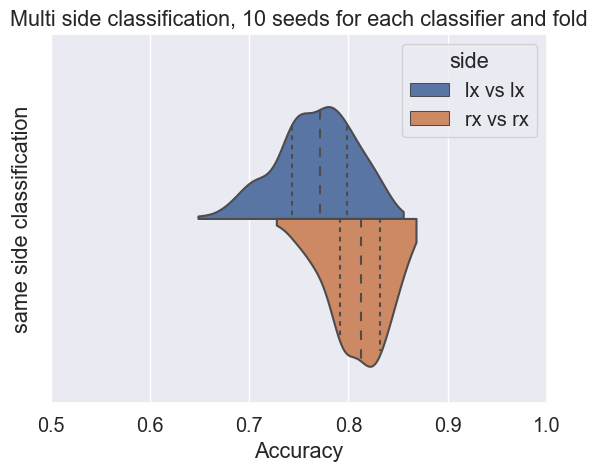

In [30]:
import matplotlib.pyplot as plt
from seaborn import violinplot

extra_col_name: str = 'same side classification'
data_to_plot = DataFrame([*selected_results_lxlx, *selected_results_rxrx], columns=[metrics_selected, "side"])
data_to_plot[extra_col_name] = ""
ax = violinplot(data_to_plot, x=metrics_selected, y=extra_col_name, hue='side', split=True, inner='quartile', cut=0)
plt.title("Multi side classification, 10 seeds for each classifier and fold")
ax.set_xlim(0.5, 1.0)
plt.show()

## LOSO

In [53]:
model_selected: str = "SVC"
metrics_selected: str = 'Accuracy'
n_seeds_to_test_classifiers: int = 30

### Test with different seeds (LX vs LX)

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [32]:
averaged_results_loso_lxlx, all_results_loso_lxlx = run_same_side_classifications(
    features_left, labels_left, groups_left, n_seeds_to_test_classifiers=n_seeds_to_test_classifiers, n_jobs=-1
)

Only one class in the dataset. Removing current user s055 <class 'RuntimeWarning'>


Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.93it/s]


In [33]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_loso_lxlx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
SVC                             0.6826            0.6826  0.6826   0.6462   
ExtraTreesClassifier            0.6717            0.6717  0.6717   0.6432   
AdaBoostClassifier              0.6577            0.6577  0.6577   0.6280   
NuSVC                           0.6554            0.6554  0.6554   0.6245   
RandomForestClassifier          0.6540            0.6540  0.6540   0.6243   
KNeighborsClassifier            0.6496            0.6496  0.6496   0.6232   
LogisticRegression              0.6383            0.6383  0.6383   0.6179   
CalibratedClassifierCV          0.6356            0.6356  0.6356   0.6164   
RidgeClassifier                 0.6356            0.6356  0.6356   0.6157   
LinearSVC                       0.6348            0.6348  0.6348   0.6153   
RidgeClassifierCV               0.6327            0.6327  0.6327   0.6128   
LinearDiscriminantAnalysis      0.6316            0.6316  0.6316   0.6125   
LabelPropagation                0.6307            0.6307  0.6307   0.6112   
LGBMClassifier                  0.6305            0.6305  0.6305   0.5957   
LabelSpreading                  0.6281            0.6281  0.6281   0.6062   
BaggingClassifier               0.6276            0.6276  0.6276   0.6056   
NearestCentroid                 0.6194            0.6194  0.6194   0.5997   
XGBClassifier                   0.6130            0.6130  0.6130   0.5799   
DecisionTreeClassifier          0.6057            0.6057  0.6057   0.5859   
ExtraTreeClassifier             0.5974            0.5974  0.5974   0.5788   
BernoulliNB                     0.5925            0.5925  0.5925   0.5663   
GaussianNB                      0.5641            0.5641  0.5641   0.4625   
SGDClassifier                   0.5611            0.5611  0.5611   0.5220   
Perceptron                      0.5483            0.5483  0.5483   0.5060   
QuadraticDiscriminantAnalysis   0.5425            0.5425  0.5425   0.4662   
PassiveAggressiveClassifier     0.5326            0.5326  0.5326   0.4779   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
SVC                               0.0144         0.0197            0.0197   
ExtraTreesClassifier              0.0870         0.0171            0.0171   
AdaBoostClassifier                0.0642         0.0156            0.0156   
NuSVC                             0.0187         0.0192            0.0192   
RandomForestClassifier            0.1343         0.0172            0.0172   
KNeighborsClassifier              0.0050         0.0151            0.0151   
LogisticRegression                0.0074         0.0273            0.0273   
CalibratedClassifierCV            0.1404         0.0272            0.0272   
RidgeClassifier                   0.0050         0.0280            0.0280   
LinearSVC                         0.0374         0.0271            0.0271   
RidgeClassifierCV                 0.0050         0.0281            0.0281   
LinearDiscriminantAnalysis        0.0050         0.0274            0.0274   
LabelPropagation                  0.0090         0.0143            0.0143   
LGBMClassifier                    0.0423         0.0173            0.0173   
LabelSpreading                    0.0121         0.0146            0.0146   
BaggingClassifier                 0.0324         0.0170            0.0170   
NearestCentroid                   0.0046         0.0286            0.0286   
XGBClassifier                     0.0918         0.0166            0.0166   
DecisionTreeClassifier            0.0079         0.0157            0.0157   
ExtraTreeClassifier       

### Test with different seeds (RX vs RX)

In [34]:
averaged_results_loso_rxrx, all_results_loso_rxrx = run_same_side_classifications(
    features_right, labels_right, groups_right, n_seeds_to_test_classifiers=n_seeds_to_test_classifiers
)

Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.55it/s]


In [35]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_loso_rxrx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier          0.7524            0.7524  0.7524   0.7327   
KNeighborsClassifier            0.7486            0.7486  0.7486   0.7373   
ExtraTreesClassifier            0.7422            0.7422  0.7422   0.7254   
NuSVC                           0.7413            0.7413  0.7413   0.7186   
XGBClassifier                   0.7409            0.7409  0.7409   0.7231   
BaggingClassifier               0.7384            0.7384  0.7384   0.7244   
LGBMClassifier                  0.7369            0.7369  0.7369   0.7174   
SVC                             0.7346            0.7346  0.7346   0.7110   
AdaBoostClassifier              0.7118            0.7118  0.7118   0.6903   
GaussianNB                      0.7040            0.7040  0.7040   0.6917   
LabelSpreading                  0.6991            0.6991  0.6991   0.6886   
NearestCentroid                 0.6965            0.6965  0.6965   0.6825   
DecisionTreeClassifier          0.6950            0.6950  0.6950   0.6808   
LinearDiscriminantAnalysis      0.6943            0.6943  0.6943   0.6769   
LabelPropagation                0.6924            0.6924  0.6924   0.6822   
RidgeClassifierCV               0.6914            0.6914  0.6914   0.6748   
RidgeClassifier                 0.6902            0.6902  0.6902   0.6740   
BernoulliNB                     0.6898            0.6898  0.6898   0.6738   
LogisticRegression              0.6896            0.6896  0.6896   0.6711   
LinearSVC                       0.6867            0.6867  0.6867   0.6682   
CalibratedClassifierCV          0.6856            0.6856  0.6856   0.6655   
ExtraTreeClassifier             0.6743            0.6743  0.6743   0.6628   
SGDClassifier                   0.6421            0.6421  0.6421   0.6134   
Perceptron                      0.6117            0.6117  0.6117   0.5778   
QuadraticDiscriminantAnalysis   0.6083            0.6083  0.6083   0.5713   
PassiveAggressiveClassifier     0.5952            0.5952  0.5952   0.5543   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier            0.1297         0.0159            0.0159   
KNeighborsClassifier              0.0049         0.0160            0.0160   
ExtraTreesClassifier              0.0843         0.0146            0.0146   
NuSVC                             0.0149         0.0179            0.0179   
XGBClassifier                     0.0893         0.0155            0.0155   
BaggingClassifier                 0.0315         0.0156            0.0156   
LGBMClassifier                    0.0439         0.0145            0.0145   
SVC                               0.0125         0.0186            0.0186   
AdaBoostClassifier                0.0637         0.0176            0.0176   
GaussianNB                        0.0046         0.0263            0.0263   
LabelSpreading                    0.0122         0.0140            0.0140   
NearestCentroid                   0.0046         0.0256            0.0256   
DecisionTreeClassifier            0.0079         0.0152            0.0152   
LinearDiscriminantAnalysis        0.0050         0.0251            0.0251   
LabelPropagation                  0.0090         0.0139            0.0139   
RidgeClassifierCV                 0.0052         0.0253            0.0253   
RidgeClassifier                   0.0051         0.0252            0.0252   
BernoulliNB                       0.0045         0.0256            0.0256   
LogisticRegression                0.0078         0.0243            0.0243   
LinearSVC                 

### Visualizing results (same side)

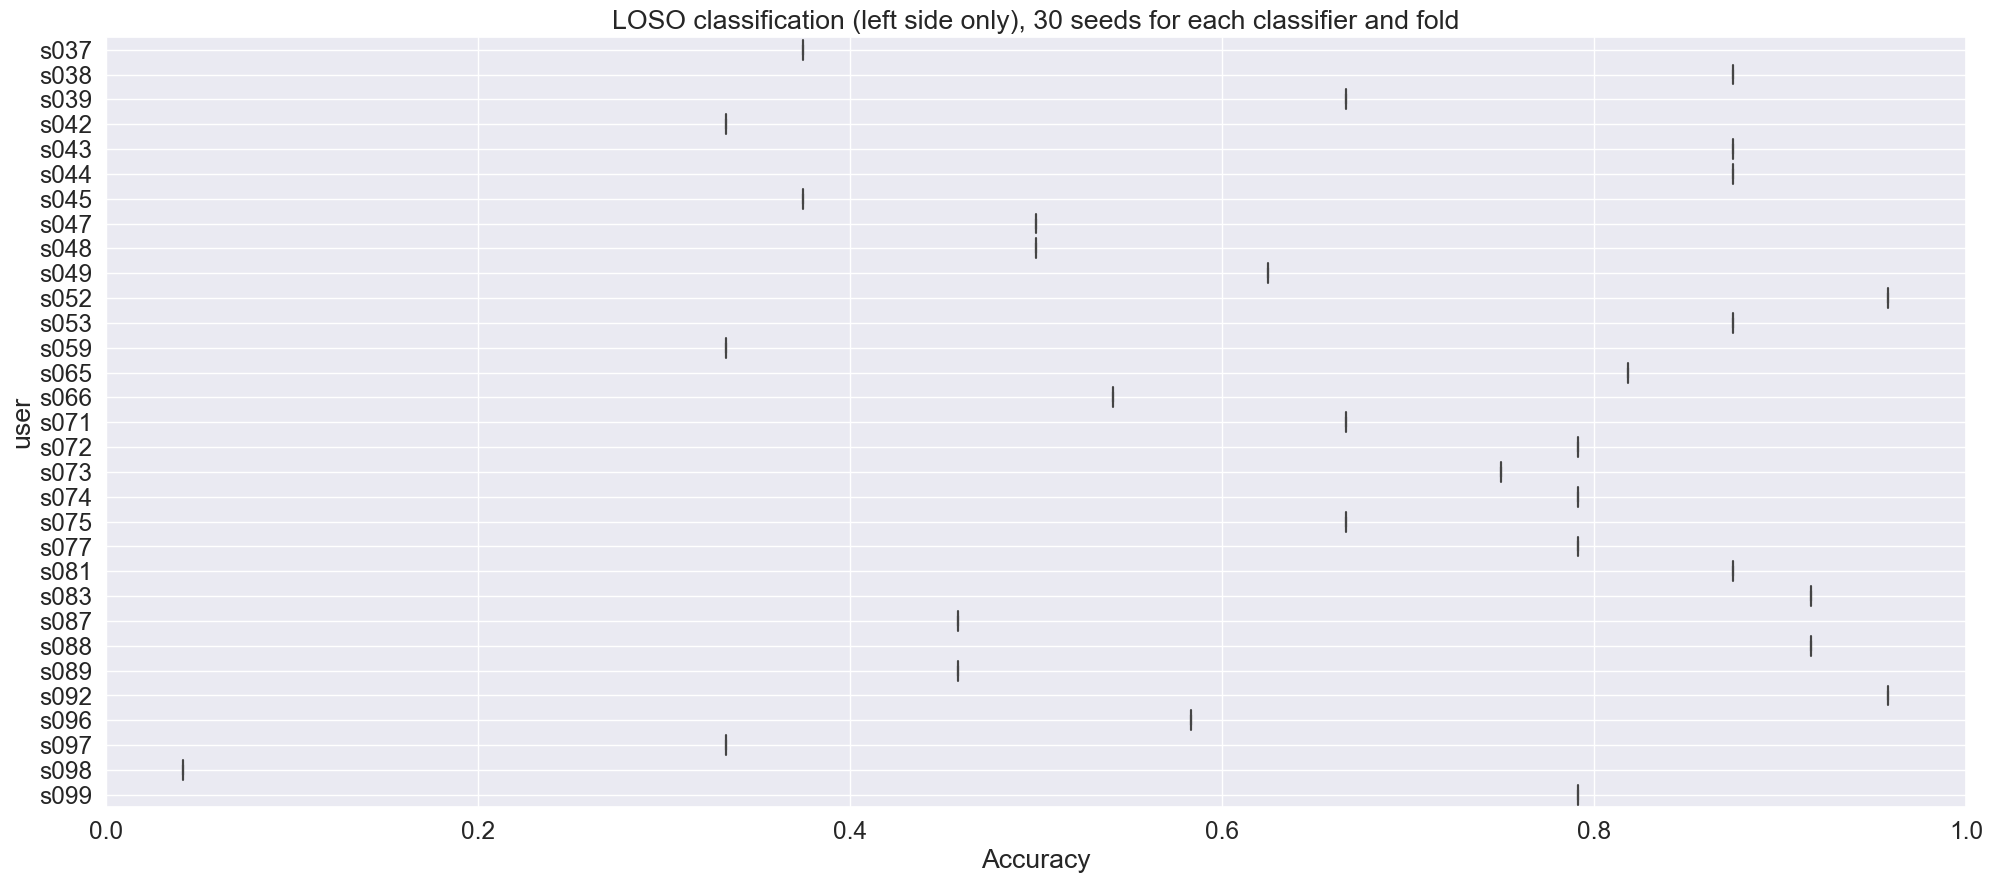

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns


selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx", single_result.columns.name)
    for seed_res in all_results_loso_lxlx
    for single_result in seed_res
]

plt.figure(figsize=(24, 10))
sns.set_context("paper")
sns.set(font_scale=1.6)
data_to_plot = DataFrame([*selected_results_lxlx], columns=[metrics_selected, "side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x=metrics_selected, y="user")
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.title(f"LOSO classification (left side only), {n_seeds_to_test_classifiers} seeds for each classifier and fold")
ax.set_xlim(0., 1.0)
plt.show()


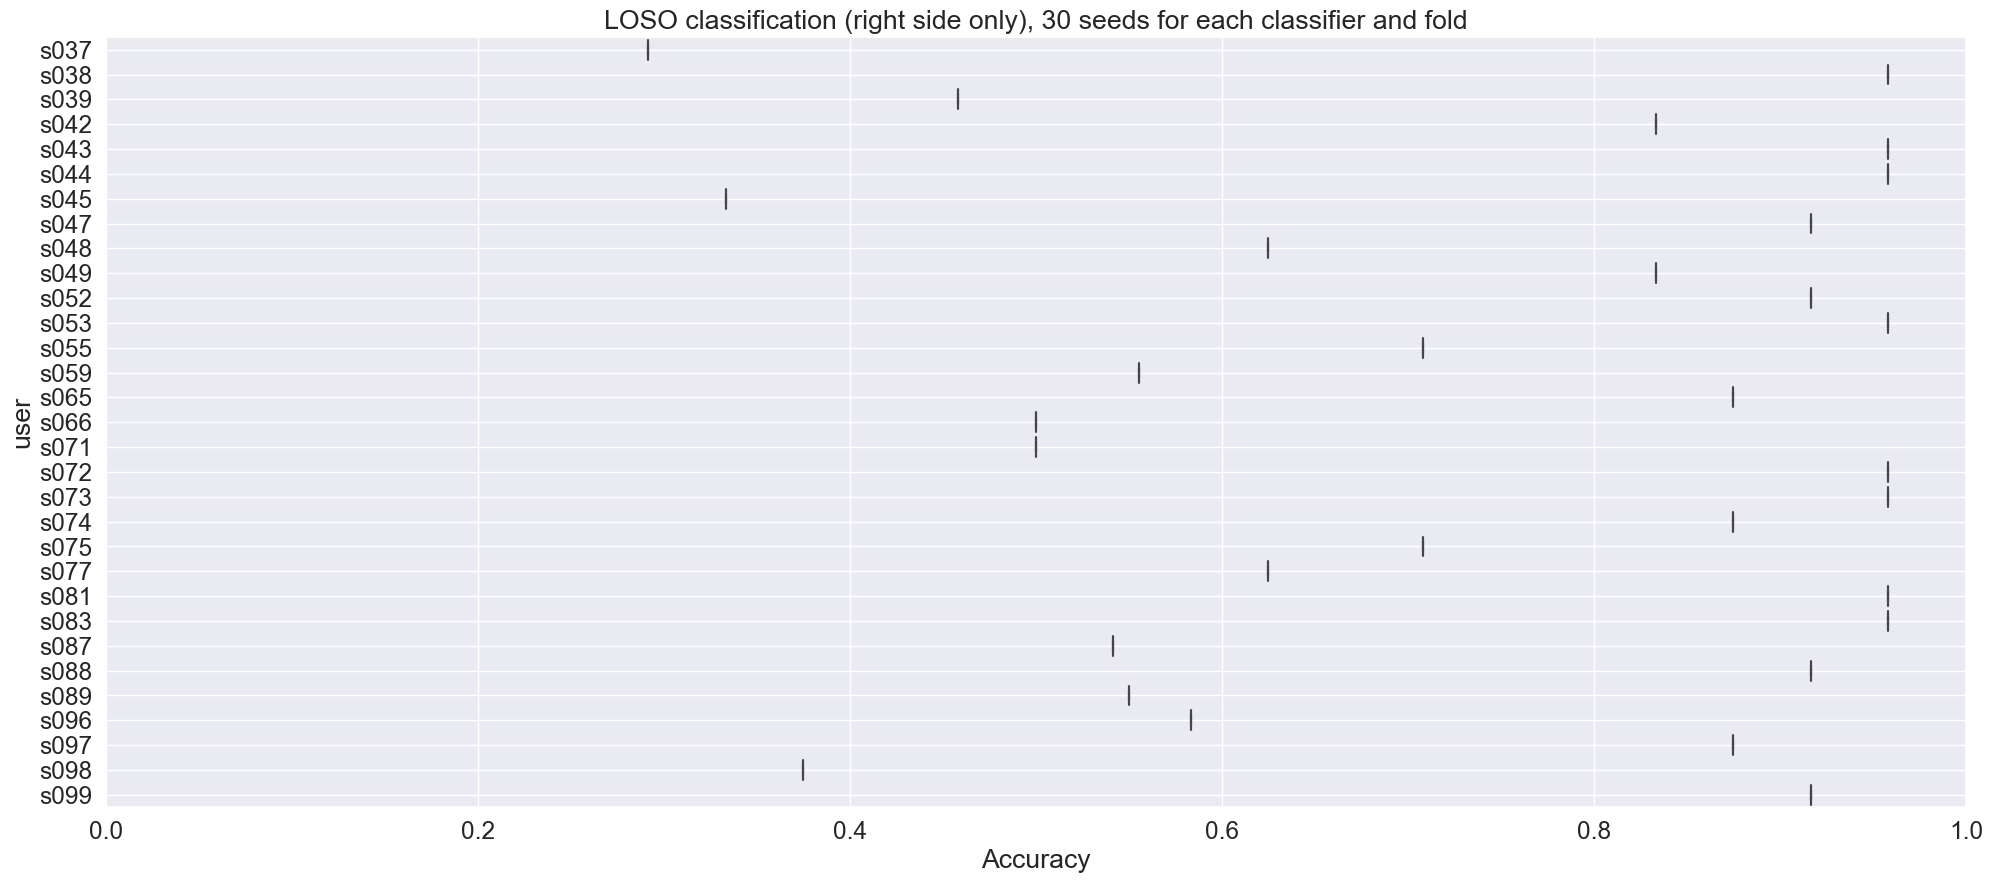

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns


selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx", single_result.columns.name)
    for seed_res in all_results_loso_rxrx
    for single_result in seed_res
]

plt.figure(figsize=(24, 10))
sns.set_context("paper")
sns.set(font_scale=1.6)
data_to_plot = DataFrame([*selected_results_rxrx], columns=[metrics_selected, "side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x=metrics_selected, y="user")
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.title(f"LOSO classification (right side only), {n_seeds_to_test_classifiers} seeds for each classifier and fold")
ax.set_xlim(0., 1.0)
plt.show()


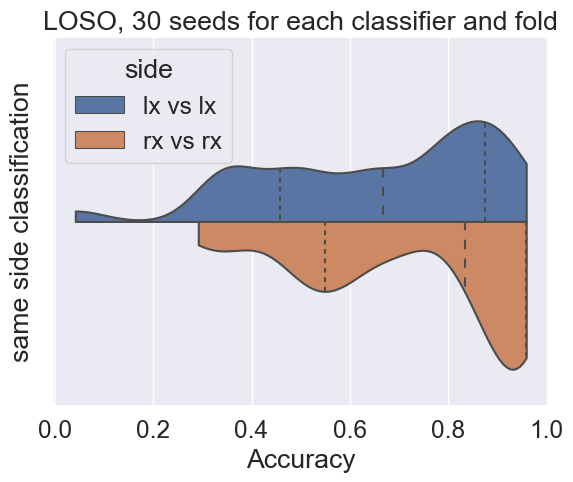

In [38]:
import matplotlib.pyplot as plt
from seaborn import violinplot

selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "rx vs rx")
    for seed_res in all_results_loso_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx")
    for seed_res in all_results_loso_lxlx
    for single_result in seed_res
]

extra_col_name: str = 'same side classification'
data_to_plot = DataFrame([*selected_results_lxlx, *selected_results_rxrx], columns=[metrics_selected, "side"])
data_to_plot[extra_col_name] = ""
ax = violinplot(data_to_plot, x=metrics_selected, y=extra_col_name, hue='side', split=True, inner='quartile', cut=0)
plt.title(f"LOSO, {n_seeds_to_test_classifiers} seeds for each classifier and fold")
# ax.set_xlim(0.5, 1.0)
plt.show()

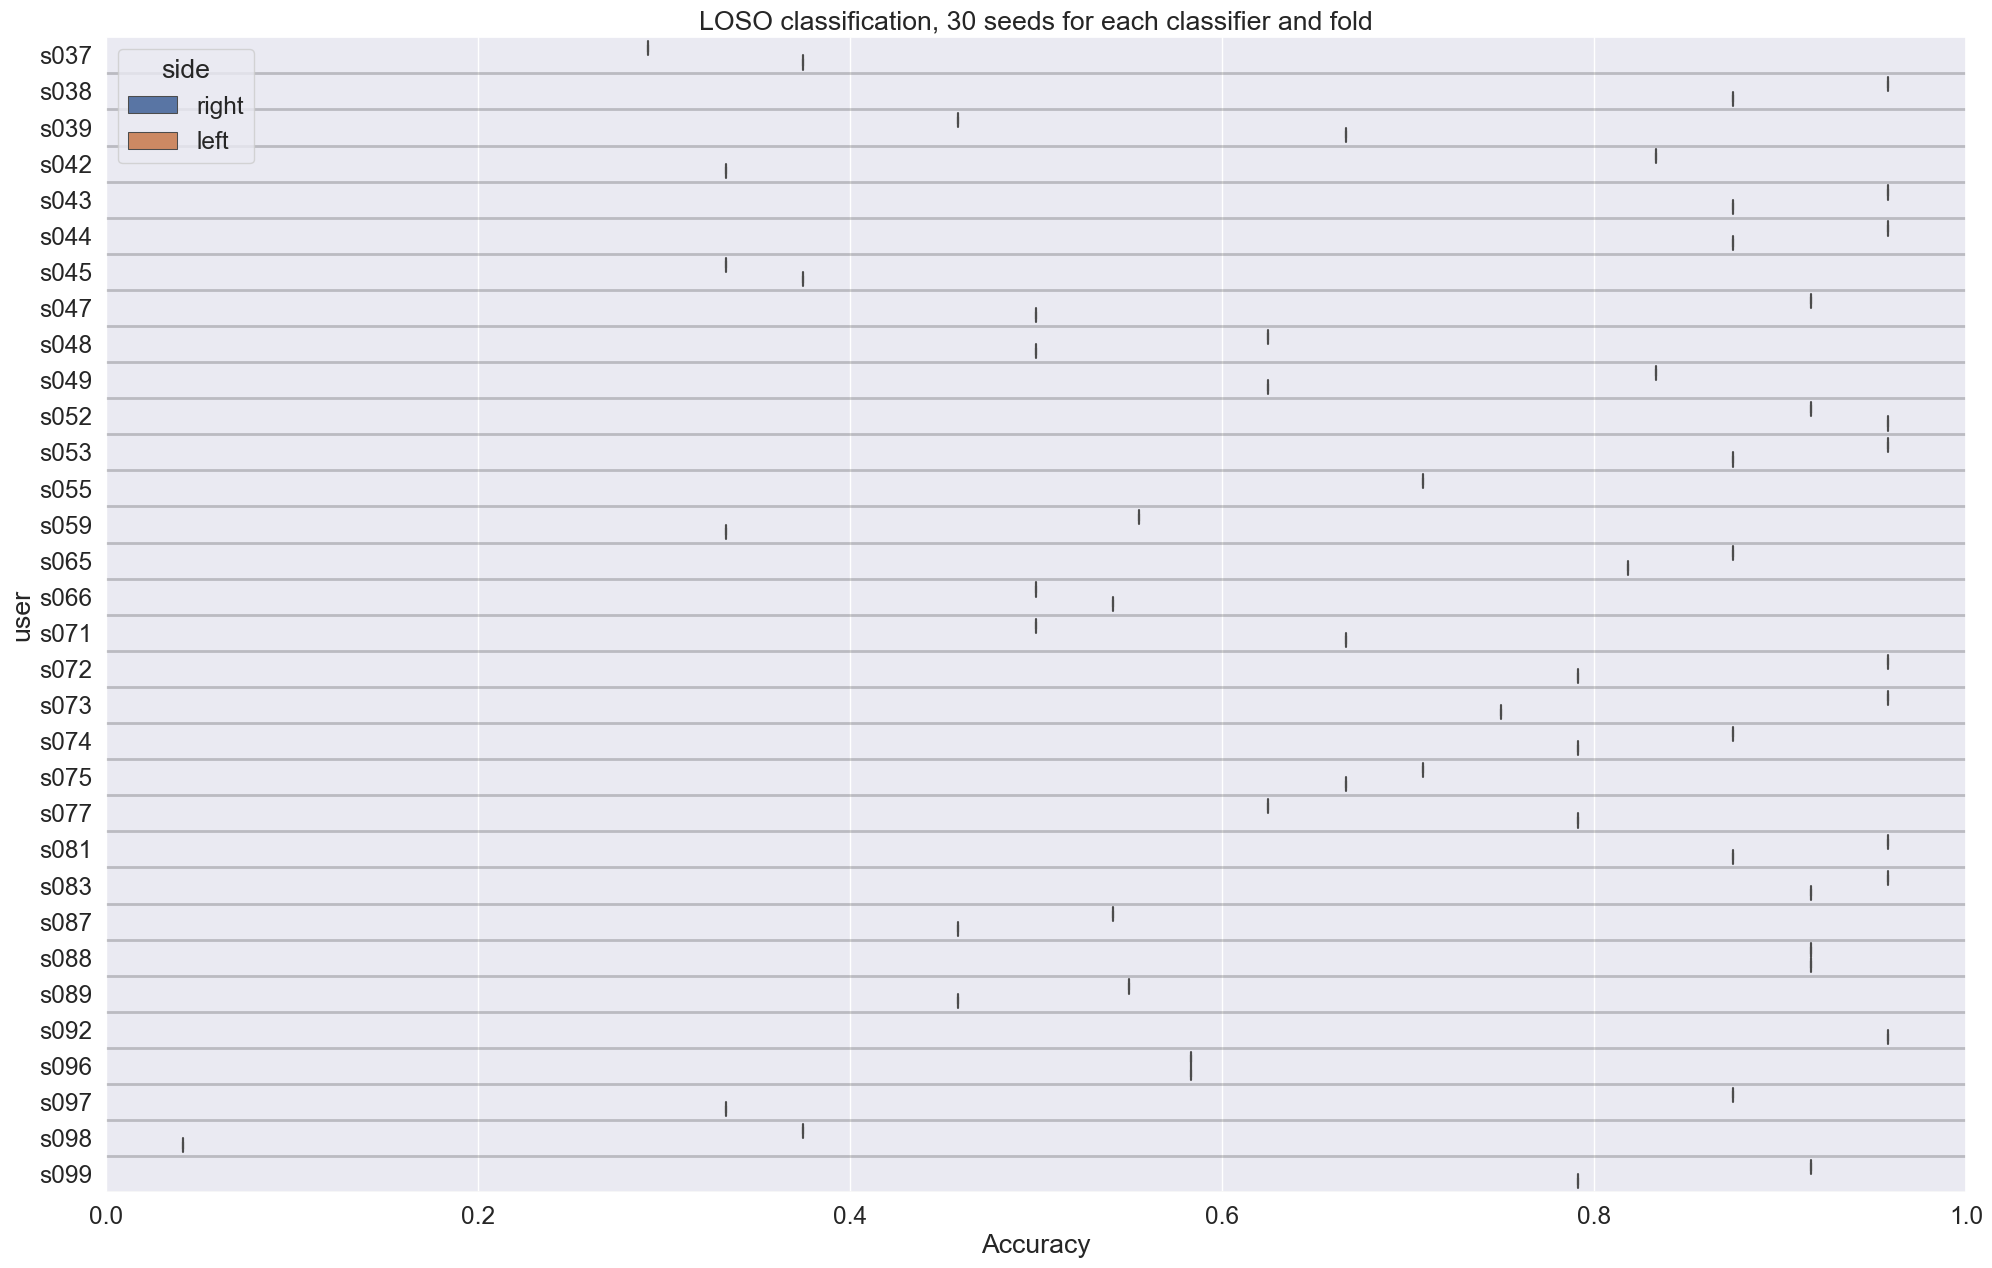

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "right", single_result.columns.name)
    for seed_res in all_results_loso_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "left", single_result.columns.name)
    for seed_res in all_results_loso_lxlx
    for single_result in seed_res
]

plt.figure(figsize=(24, 15))
sns.set_context("paper")
sns.set(font_scale=1.6)
data_to_plot = DataFrame([*selected_results_rxrx, *selected_results_lxlx], columns=[metrics_selected, "side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x=metrics_selected, y="user", hue='side')
ax.xaxis.grid(True)
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.grid(True, which='minor', linestyle='-', linewidth=2, color='black', alpha=0.2)
# ax.yaxis.grid(True, which='major', linestyle='-', linewidth=13, color='orange', alpha=0.3)
plt.title(f"LOSO classification, {n_seeds_to_test_classifiers} seeds for each classifier and fold")
ax.set_xlim(0., 1.0) 
plt.show()


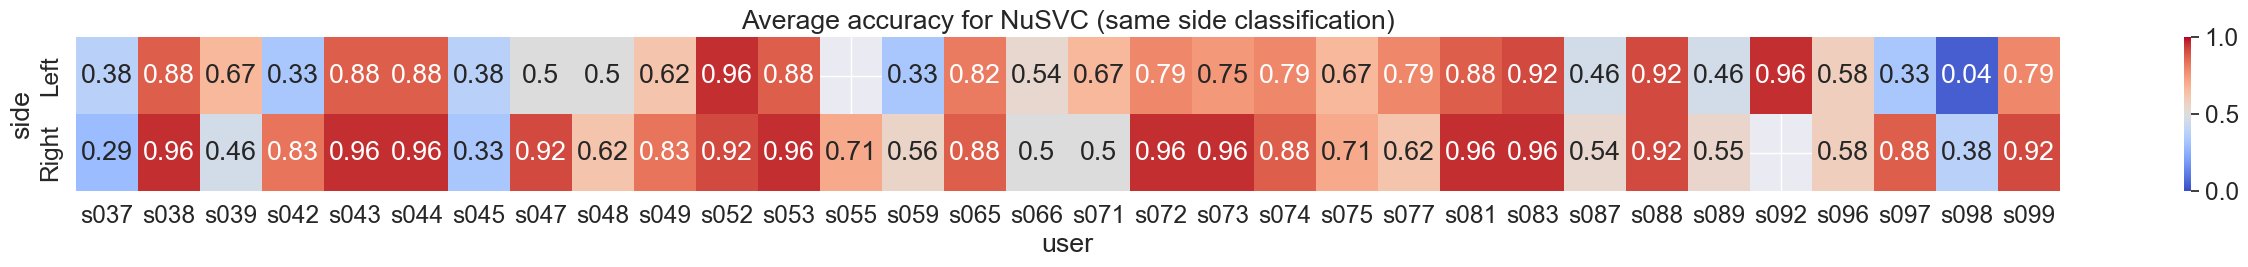

In [40]:
data_to_plot2 = data_to_plot.groupby(['user', 'side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
plt.figure(figsize=(len(data_to_plot2.columns), 2))
ax = sns.heatmap(data_to_plot2, 
            yticklabels=['Left', 'Right'],
            cmap='coolwarm', 
            annot=data_to_plot2.round(decimals=2),
            vmin=0, vmax=1,
            center=0.5,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy for {model_selected} (same side classification)")
plt.show()

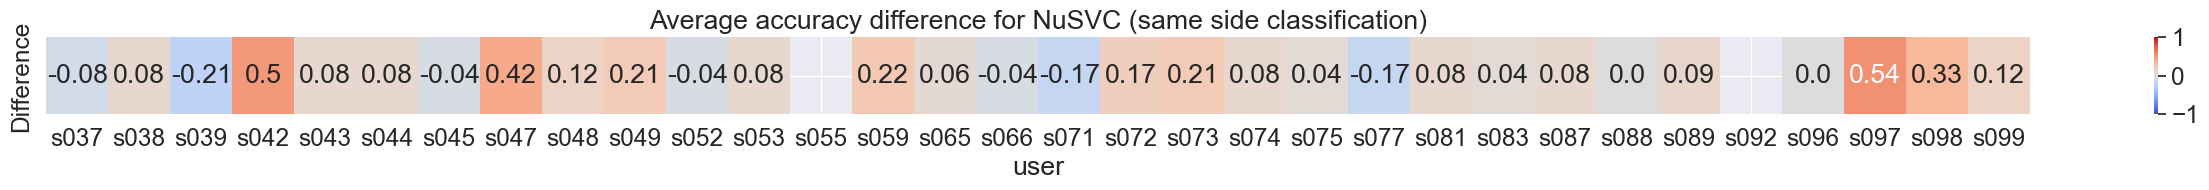

In [41]:
data_to_plot2 = data_to_plot.groupby(['user', 'side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
data_to_plot3 = data_to_plot2.iloc[1,:] - data_to_plot2.iloc[0,:]
data_to_plot3 = DataFrame(data_to_plot3, columns=['Difference']).T

plt.figure(figsize=(len(data_to_plot3.columns),1))
ax = sns.heatmap(data_to_plot3, 
            yticklabels=['Difference'],
            cmap='coolwarm', 
            annot=data_to_plot3.round(decimals=2).values,
            vmin=-1, vmax=1,
            center=0,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy difference for {model_selected} (same side classification)")
plt.show()

Here is it noted that the distribution of labels across each individual is the same as the total, since the duration of the experiment was them same. It is also noted that a per-user undersampling is performed.

### Test with different seeds (LX vs RX)

In [42]:
averaged_results_loso_lxrx, all_results_loso_lxrx = run_different_classifications(
    x_train=features_left,
    x_test=features_right,
    y_train=labels_left,
    y_test=labels_right,
    folds_train=groups_left,
    folds_test=groups_right,
    n_seeds_to_test_classifiers=n_seeds_to_test_classifiers,
    n_jobs=-1,
)

Only one class in the dataset. Removing current user s055 <class 'RuntimeWarning'>


Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 37.87it/s]

100%|██████████| 29/29 [00:00<00:00, 44.72it/s]


In [43]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_loso_lxrx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
SVC                             0.7557            0.7557  0.7557   0.7373   
KNeighborsClassifier            0.7391            0.7391  0.7391   0.7246   
ExtraTreesClassifier            0.7267            0.7267  0.7267   0.7123   
NuSVC                           0.7198            0.7198  0.7198   0.6974   
RandomForestClassifier          0.7127            0.7127  0.7127   0.6955   
CalibratedClassifierCV          0.7093            0.7093  0.7093   0.6896   
LabelSpreading                  0.7073            0.7073  0.7073   0.6951   
LogisticRegression              0.7042            0.7042  0.7042   0.6872   
AdaBoostClassifier              0.7017            0.7017  0.7017   0.6833   
RidgeClassifier                 0.6981            0.6981  0.6981   0.6808   
LinearSVC                       0.6980            0.6980  0.6980   0.6820   
LabelPropagation                0.6971            0.6971  0.6971   0.6845   
RidgeClassifierCV               0.6965            0.6965  0.6965   0.6802   
LinearDiscriminantAnalysis      0.6954            0.6954  0.6954   0.6774   
NearestCentroid                 0.6894            0.6894  0.6894   0.6693   
XGBClassifier                   0.6778            0.6778  0.6778   0.6669   
LGBMClassifier                  0.6769            0.6769  0.6769   0.6665   
BaggingClassifier               0.6650            0.6650  0.6650   0.6514   
ExtraTreeClassifier             0.6460            0.6460  0.6460   0.6333   
BernoulliNB                     0.6375            0.6375  0.6375   0.6172   
DecisionTreeClassifier          0.6270            0.6270  0.6270   0.6145   
SGDClassifier                   0.5990            0.5990  0.5990   0.5600   
QuadraticDiscriminantAnalysis   0.5714            0.5714  0.5714   0.4967   
Perceptron                      0.5653            0.5653  0.5653   0.5230   
PassiveAggressiveClassifier     0.5504            0.5504  0.5504   0.4947   
GaussianNB                      0.5406            0.5406  0.5406   0.4392   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
SVC                               0.0142         0.0158            0.0158   
KNeighborsClassifier              0.0049         0.0144            0.0144   
ExtraTreesClassifier              0.0874         0.0147            0.0147   
NuSVC                             0.0186         0.0164            0.0164   
RandomForestClassifier            0.1343         0.0147            0.0147   
CalibratedClassifierCV            0.1403         0.0252            0.0252   
LabelSpreading                    0.0120         0.0124            0.0124   
LogisticRegression                0.0074         0.0259            0.0259   
AdaBoostClassifier                0.0639         0.0137            0.0137   
RidgeClassifier                   0.0050         0.0272            0.0272   
LinearSVC                         0.0376         0.0269            0.0269   
LabelPropagation                  0.0090         0.0121            0.0121   
RidgeClassifierCV                 0.0051         0.0273            0.0273   
LinearDiscriminantAnalysis        0.0050         0.0271            0.0271   
NearestCentroid                   0.0045         0.0268            0.0268   
XGBClassifier                     0.0917         0.0156            0.0156   
LGBMClassifier                    0.0422         0.0145            0.0145   
BaggingClassifier                 0.0323         0.0152            0.0152   
ExtraTreeClassifier               0.0046         0.0123            0.0123   
BernoulliNB               

### Test with different seeds (RX vs LX)

In [44]:
averaged_results_loso_rxlx, all_results_loso_rxlx = run_different_classifications(
    x_train=features_right,
    x_test=features_left,
    y_train=labels_right,
    y_test=labels_left,
    folds_train=groups_right,
    folds_test=groups_left,
    n_jobs=6,
    n_seeds_to_test_classifiers=n_seeds_to_test_classifiers,
)

Only one class in the dataset. Removing current user s055 <class 'RuntimeWarning'>


Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 44.79it/s]

100%|██████████| 29/29 [00:00<00:00, 47.31it/s]


In [45]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_loso_rxlx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
LGBMClassifier                  0.6870            0.6870  0.6870   0.6670   
KNeighborsClassifier            0.6816            0.6816  0.6816   0.6582   
LabelSpreading                  0.6769            0.6769  0.6769   0.6637   
LabelPropagation                0.6769            0.6769  0.6769   0.6637   
XGBClassifier                   0.6756            0.6756  0.6756   0.6545   
RandomForestClassifier          0.6674            0.6674  0.6674   0.6407   
ExtraTreesClassifier            0.6659            0.6659  0.6659   0.6433   
BaggingClassifier               0.6599            0.6599  0.6599   0.6399   
AdaBoostClassifier              0.6520            0.6520  0.6520   0.6220   
SVC                             0.6480            0.6480  0.6480   0.6156   
NuSVC                           0.6437            0.6437  0.6437   0.6160   
GaussianNB                      0.6415            0.6415  0.6415   0.6130   
ExtraTreeClassifier             0.6367            0.6367  0.6367   0.6222   
NearestCentroid                 0.6304            0.6304  0.6304   0.6071   
RidgeClassifierCV               0.6260            0.6260  0.6260   0.6044   
LinearDiscriminantAnalysis      0.6246            0.6246  0.6246   0.6071   
DecisionTreeClassifier          0.6225            0.6225  0.6225   0.6025   
RidgeClassifier                 0.6205            0.6205  0.6205   0.5999   
LinearSVC                       0.6164            0.6164  0.6164   0.5984   
LogisticRegression              0.6162            0.6162  0.6162   0.5990   
BernoulliNB                     0.6138            0.6138  0.6138   0.5876   
CalibratedClassifierCV          0.6121            0.6121  0.6121   0.5912   
SGDClassifier                   0.5965            0.5965  0.5965   0.5666   
QuadraticDiscriminantAnalysis   0.5938            0.5938  0.5938   0.5504   
Perceptron                      0.5729            0.5729  0.5729   0.5371   
PassiveAggressiveClassifier     0.5619            0.5619  0.5619   0.5186   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
LGBMClassifier                    0.0388         0.0200            0.0200   
KNeighborsClassifier              0.0041         0.0187            0.0187   
LabelSpreading                    0.0104         0.0159            0.0159   
LabelPropagation                  0.0077         0.0158            0.0158   
XGBClassifier                     0.0773         0.0201            0.0201   
RandomForestClassifier            0.1094         0.0215            0.0215   
ExtraTreesClassifier              0.0706         0.0209            0.0209   
BaggingClassifier                 0.0275         0.0202            0.0202   
AdaBoostClassifier                0.0549         0.0226            0.0226   
SVC                               0.0106         0.0223            0.0223   
NuSVC                             0.0125         0.0221            0.0221   
GaussianNB                        0.0038         0.0274            0.0274   
ExtraTreeClassifier               0.0037         0.0177            0.0177   
NearestCentroid                   0.0039         0.0296            0.0296   
RidgeClassifierCV                 0.0043         0.0280            0.0280   
LinearDiscriminantAnalysis        0.0042         0.0279            0.0279   
DecisionTreeClassifier            0.0066         0.0177            0.0177   
RidgeClassifier                   0.0042         0.0276            0.0276   
LinearSVC                         0.0329         0.0279            0.0279   
LogisticRegression        

These results suggest that the test set is the one having the greater importance in the performance of "different sides classifier". However, it is unclear if this is due actual lateralization effect, or due to other factors in play, e.g., artefacts.

### Visualizing results (different side)

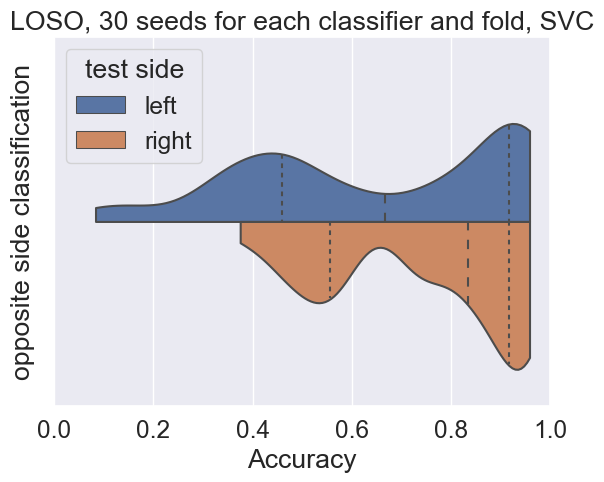

In [59]:
import matplotlib.pyplot as plt
from seaborn import violinplot

selected_results_lxrx = [
    (single_result.loc[model_selected, metrics_selected], "right")
    for seed_res in all_results_loso_lxrx
    for single_result in seed_res
    if len(single_result) > 0
]

selected_results_rxlx = [
    (single_result.loc[model_selected, metrics_selected], "left")
    for seed_res in all_results_loso_rxlx
    for single_result in seed_res
    if len(single_result) > 0
]

extra_col_name: str = 'opposite side classification'
data_to_plot = DataFrame([*selected_results_rxlx, *selected_results_lxrx], columns=[metrics_selected, "test side"])
data_to_plot[extra_col_name] = ""
ax = violinplot(data_to_plot, x=metrics_selected, y=extra_col_name, hue='test side', split=True, inner='quartile', cut=0)
plt.title(f"LOSO, {n_seeds_to_test_classifiers} seeds for each classifier and fold, {model_selected}")
ax.set_xlim(0., 1.0)
plt.show()

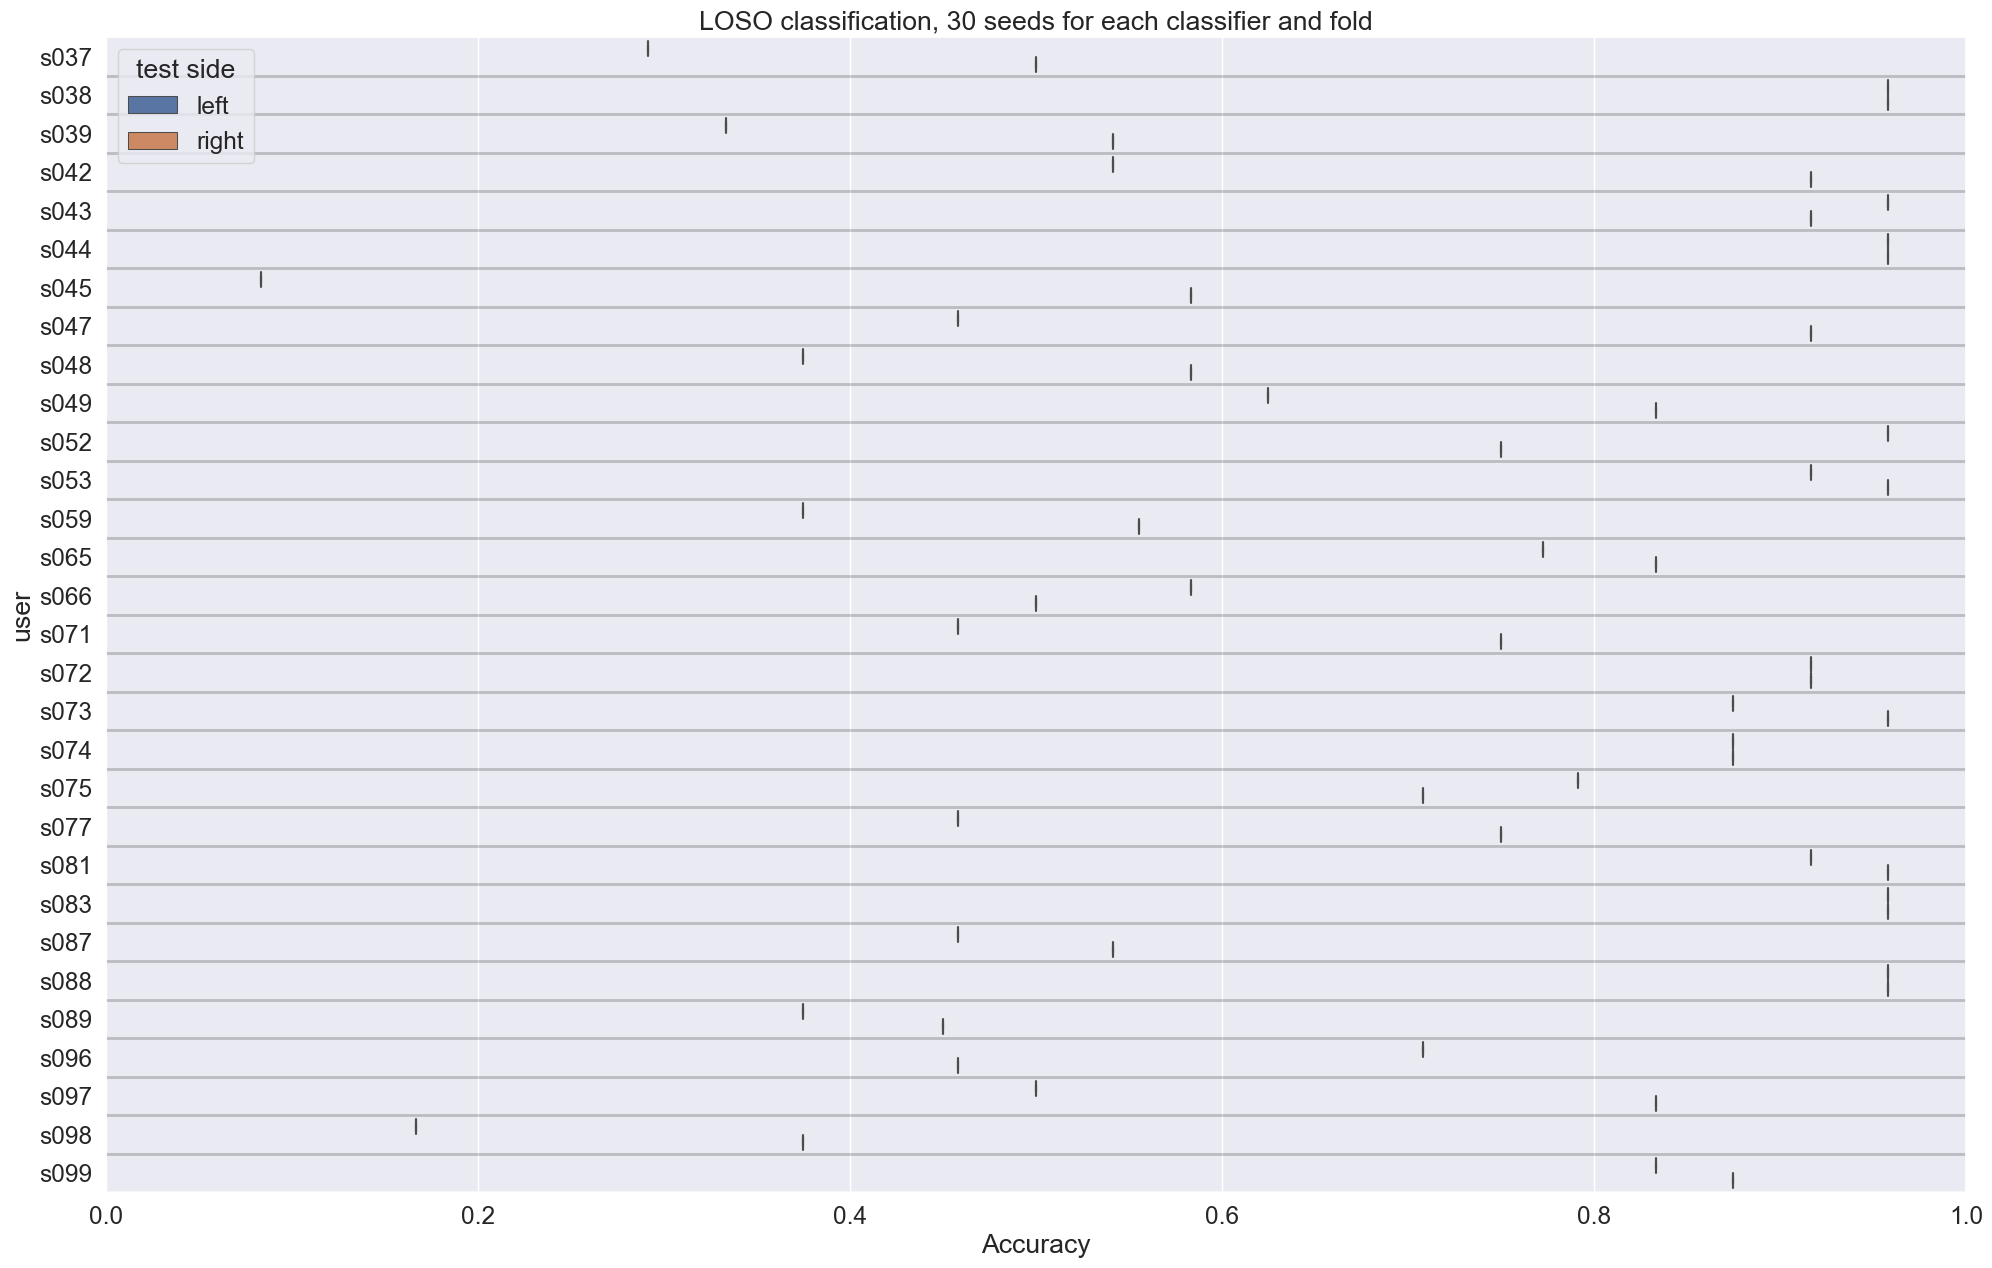

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

selected_results_lxrx = [
    (single_result.loc[model_selected, metrics_selected], "right", single_result.columns.name)
    for seed_res in all_results_loso_lxrx
    for single_result in seed_res
    if len(single_result) > 0
]

selected_results_rxlx = [
    (single_result.loc[model_selected, metrics_selected], "left", single_result.columns.name)
    for seed_res in all_results_loso_rxlx
    for single_result in seed_res
    if len(single_result) > 0
]

plt.figure(figsize=(24, 15))
sns.set_context("paper")
sns.set(font_scale=1.6)
data_to_plot = DataFrame([*selected_results_lxrx, *selected_results_rxlx], columns=[metrics_selected, "test side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x=metrics_selected, y="user", hue='test side')
ax.xaxis.grid(True)
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.grid(True, which='minor', linestyle='-', linewidth=2, color='black', alpha=0.2)
# ax.yaxis.grid(True, which='major', linestyle='-', linewidth=13, color='orange', alpha=0.3)
plt.title(f"LOSO classification, {n_seeds_to_test_classifiers} seeds for each classifier and fold")
ax.set_xlim(0., 1.0) 
plt.show()


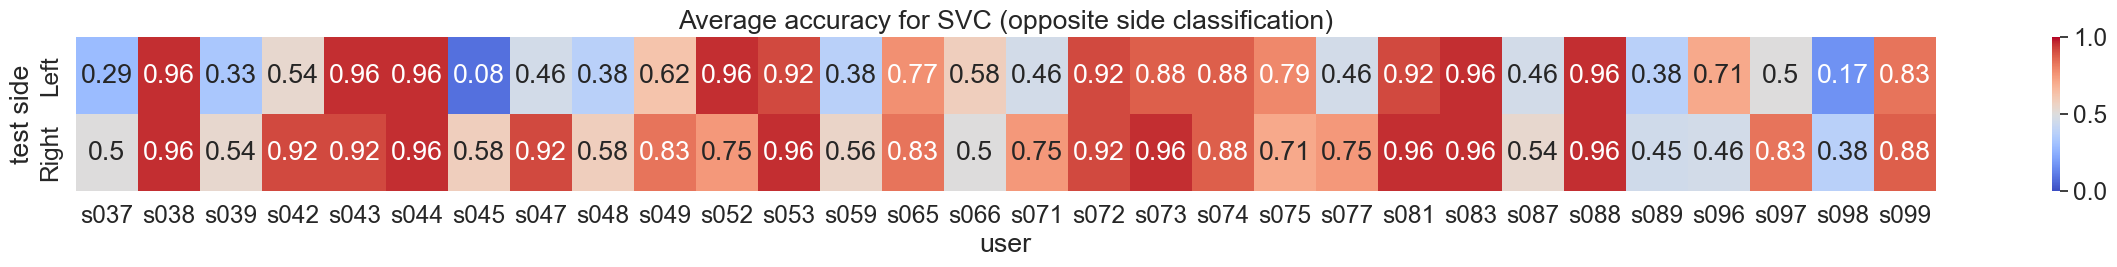

In [61]:
data_to_plot2 = data_to_plot.groupby(['user', 'test side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
plt.figure(figsize=(len(data_to_plot2.columns), 2))
ax = sns.heatmap(data_to_plot2, 
            yticklabels=['Left', 'Right'],
            cmap='coolwarm', 
            annot=data_to_plot2.round(decimals=2),
            vmin=0, vmax=1,
            center=0.5,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy for {model_selected} (opposite side classification)")
plt.show()

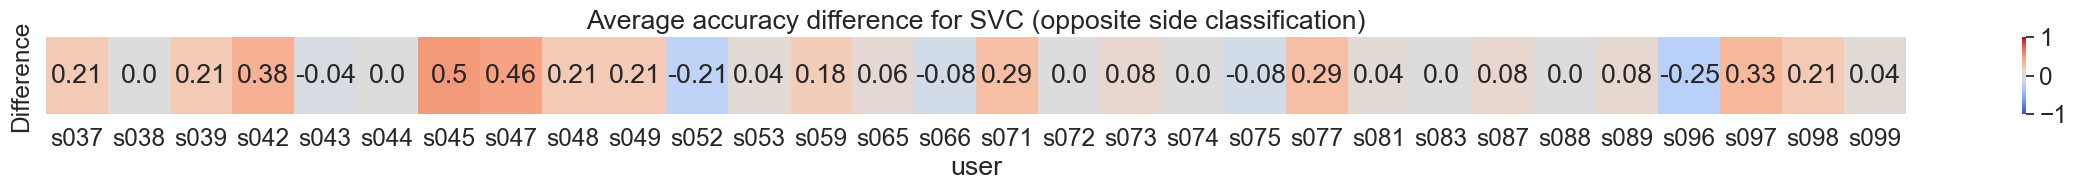

In [62]:
data_to_plot2 = data_to_plot.groupby(['user', 'test side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
data_to_plot3 = data_to_plot2.iloc[1,:] - data_to_plot2.iloc[0,:]
data_to_plot3 = DataFrame(data_to_plot3, columns=['Difference']).T

plt.figure(figsize=(len(data_to_plot3.columns),1))
ax = sns.heatmap(data_to_plot3, 
            yticklabels=['Difference'],
            cmap='coolwarm', 
            annot=data_to_plot3.round(decimals=2).values,
            vmin=-1, vmax=1,
            center=0,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy difference for {model_selected} (opposite side classification)")
plt.show()

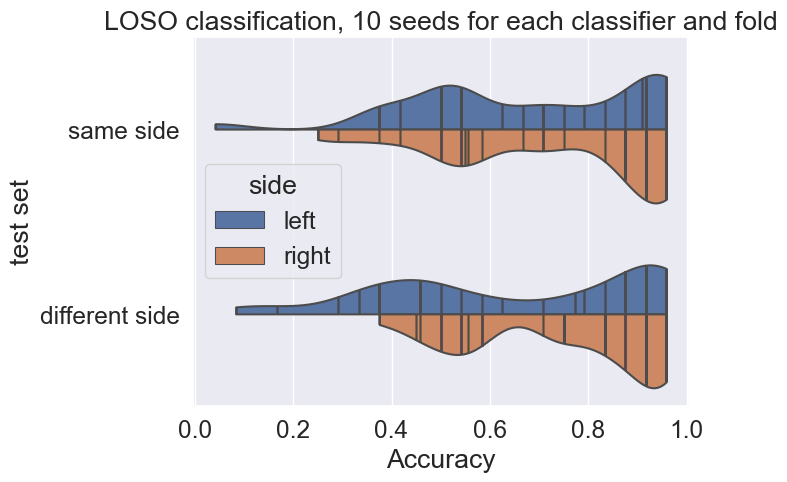

In [64]:
import matplotlib.pyplot as plt
from seaborn import violinplot

selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "right", "same side")
    for seed_res in all_results_loso_rxrx
    for single_result in seed_res
    if len(single_result) > 0
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "left", "same side")
    for seed_res in all_results_loso_lxlx
    for single_result in seed_res
    if len(single_result) > 0
]

selected_results_lxrx = [
    (single_result.loc[model_selected, metrics_selected], "right", "different side")
    for seed_res in all_results_loso_lxrx
    for single_result in seed_res
    if len(single_result) > 0
]

selected_results_rxlx = [
    (single_result.loc[model_selected, metrics_selected], "left", "different side")
    for seed_res in all_results_loso_rxlx
    for single_result in seed_res
    if len(single_result) > 0
]

data_to_plot = DataFrame([*selected_results_lxlx, *selected_results_rxrx, *selected_results_lxrx, *selected_results_rxlx], columns=[metrics_selected, "side", "test set"])
ax = violinplot(data_to_plot, x=metrics_selected, y="test set", hue='side', split=True, inner='stick', cut=0)
plt.title("LOSO classification, 10 seeds for each classifier and fold")
# ax.set_xlim(0.5, 1.0)
plt.show()